## Import Library & Dataset

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('./amazon-employee-access-challenge/train.csv')
print(data.shape)
data.head()

(32769, 10)


,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


## Data Exploration

In [4]:
data_explore = data.copy()

In [5]:
data_explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


There is no column with null values.

In [6]:
data_explore.nunique()

ACTION                 2
RESOURCE            7518
MGR_ID              4243
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_TITLE           343
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
ROLE_CODE            343
dtype: int64

- In dataset description it is mention that an employee can have only one manager at a time, then we can consider that the dataset contains information of maximum 4243 employees.
- There are same number of unique values for ROLE_TITLE and ROLE_CODE. There is 1-to-1 mapping between these columns. So for our problem only one feature is sufficent.

<AxesSubplot:xlabel='ACTION', ylabel='count'>

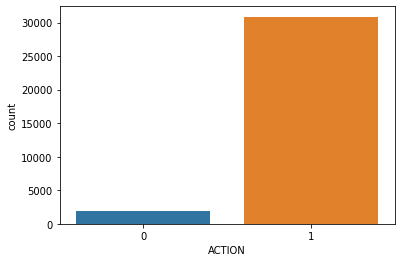

In [7]:
sns.countplot(x='ACTION', data=data_explore)

- We can see that we have imbalance dataset. There are very less records of not granting the access.

- Lets find out top 15 Resources, Role department, Role family, Role codes for which most access is requested.

In [8]:
data_explore_resources = data_explore[['RESOURCE', "ACTION"]].groupby(by='RESOURCE').count()
data_explore_resources.sort_values('ACTION', ascending=False).head(n=15).transpose()

RESOURCE,4675,79092,25993,75078,3853,75834,6977,32270,42085,17308,1020,13878,42093,18418,7543
ACTION,839,484,409,409,404,299,299,295,247,239,236,220,204,192,186


In [9]:
data_explore_role_dept = data_explore[['ROLE_DEPTNAME', "ACTION"]].groupby(by='ROLE_DEPTNAME').count()
data_explore_role_dept.sort_values('ACTION', ascending=False).head(n=15).transpose()

ROLE_DEPTNAME,117878,117941,117945,118514,117920,117884,119598,118403,119181,120722,118320,117895,118746,118783,120663
ACTION,1135,763,659,601,597,546,543,532,525,501,435,431,415,366,335


In [10]:
data_explore_role_codes = data_explore[['ROLE_CODE', "ACTION"]].groupby(by='ROLE_CODE').count()
data_explore_role_codes.sort_values('ACTION', ascending=False).head(n=15).transpose()

ROLE_CODE,118322,117908,118786,117880,118570,117888,118055,118687,118779,118454,120346,118332,119082,117973,118425
ACTION,4649,3583,1772,1256,1043,806,774,597,566,521,473,467,394,384,376


In [11]:
data_explore_role_family = data_explore[['ROLE_FAMILY', "ACTION"]].groupby(by='ROLE_FAMILY').count()
data_explore_role_family.sort_values('ACTION', ascending=False).head(n=15).transpose()

ROLE_FAMILY,290919,118424,19721,117887,292795,118398,308574,118453,118331,118643,118638,270488,118295,118960,118205
ACTION,10980,2690,2636,2400,1318,1294,1287,941,892,783,783,689,493,465,449


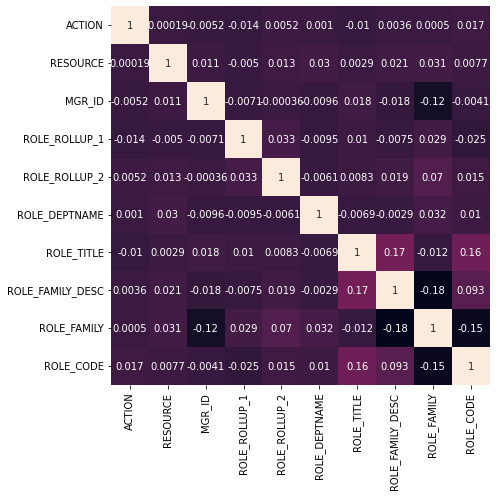

In [12]:
plt.figure(figsize=(12, 7))
corr_matrix = data_explore.corr()
sns.heatmap(corr_matrix, mask=np.zeros_like(corr_matrix, dtype=np.bool), square=True, annot=True, cbar=False)
plt.tight_layout()

In [13]:
corr_matrix['ACTION'].sort_values(ascending=False)

ACTION              1.000000
ROLE_CODE           0.017147
ROLE_ROLLUP_2       0.005179
ROLE_FAMILY_DESC    0.003565
ROLE_DEPTNAME       0.001025
ROLE_FAMILY         0.000502
RESOURCE            0.000185
MGR_ID             -0.005167
ROLE_TITLE         -0.010169
ROLE_ROLLUP_1      -0.013702
Name: ACTION, dtype: float64

- There is no attribute to which target variable is strongly correlated.

## Data Preprocessing

In [14]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [15]:
X = data.drop(columns=['ACTION'], axis=1).copy()
y = data['ACTION'].copy()
X.shape, y.shape

((32769, 9), (32769,))

In [16]:
cat_attrs = list(X.columns)
cat_attrs

['RESOURCE',
 'MGR_ID',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_2',
 'ROLE_DEPTNAME',
 'ROLE_TITLE',
 'ROLE_FAMILY_DESC',
 'ROLE_FAMILY',
 'ROLE_CODE']

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X, y):
    strat_train_set = data.iloc[train_index]
    strat_test_set = data.iloc[test_index]

X_train = strat_train_set.drop('ACTION', axis=1)
y_train = strat_train_set['ACTION'].copy()
X_test = strat_test_set.drop('ACTION', axis=1)
y_test = strat_test_set['ACTION'].copy()
X_train.shape, X_test.shape

((26215, 9), (6554, 9))

In [18]:
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                         ('cat_enc', OneHotEncoder(handle_unknown='ignore'))])

pre_process = ColumnTransformer([('cat_process', cat_pipeline, cat_attrs)], remainder='passthrough')

X_train_transformed = pre_process.fit_transform(X_train)
X_test_transformed = pre_process.transform(X_test)
X_train_transformed.shape, X_test_transformed.shape

((26215, 14410), (6554, 14410))

- Since I will be using CatBoost Classifier. For CatBoost model, there is no need of encoding categorical model. Hence I will be creating a separate preprocessing pipeline for CatBoost model.

In [19]:
cat_boost_pre_process = ColumnTransformer([('imputer', SimpleImputer(strategy='most_frequent'), cat_attrs)], remainder='passthrough')

X_cb_train_transformed = cat_boost_pre_process.fit_transform(X_train)
X_cb_test_transformed = cat_boost_pre_process.transform(X_test)
X_cb_train_transformed.shape, X_cb_test_transformed.shape

((26215, 9), (6554, 9))

In [20]:
feature_columns = list(pre_process.transformers_[0][1]['cat_enc'].get_feature_names(cat_attrs))
len(feature_columns)

14410

## Modelling

- Evaluation metric for this competition is ROC AUC Score.
- Since we have imbalance dataset, I will use Matthews correlation coefficient (MCC) as another evaluation metric. 
- Value of MCC is lies between -1 to +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction.
    - ${MCC} = \frac{(TP + TN) * (FP + FN)}{\sqrt{( (TP +FP) * (TP + FN) * (TN + FP) * (TN + FN))}}$
    
- MCC value will be high only if model has high accuracy on predictions of negative data instances as well as of positive data instances.
- I will be selecting the best model with highest ROC AUC Score.

In [21]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [22]:
from sklearn.metrics import matthews_corrcoef, make_scorer, roc_auc_score, roc_curve
Matthew = make_scorer(matthews_corrcoef)

results = []

def plot_custom_roc_curve(clf_name, y_true, y_scores):
    auc_score = np.round(roc_auc_score(y_true, y_scores), 3)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr, linewidth=2, label=clf_name+" (AUC Score: {})".format(str(auc_score)))
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel("FPR", fontsize=16)
    plt.ylabel("TPR", fontsize=16)
    plt.legend()
    
    
def performance_measures(model, X_tr=X_train_transformed, y_tr=y_train, X_ts=X_test_transformed, y_ts=y_test,
                         store_results=True):
    train_mcc = cross_val_score(model, X_tr, y_tr, scoring=Matthew, cv=kf, n_jobs=-1)
    test_mcc = cross_val_score(model, X_ts, y_ts, scoring=Matthew, cv=kf, n_jobs=-1)
    print("Mean Train MCC: {}\nMean Test MCC: {}".format(train_mcc.mean(), test_mcc.mean()))

    
    train_roc_auc = cross_val_score(model, X_tr, y_tr, scoring='roc_auc', cv=kf, n_jobs=-1)
    test_roc_auc = cross_val_score(model, X_ts, y_ts, scoring='roc_auc', cv=kf, n_jobs=-1)
    print("Mean Train ROC AUC Score: {}\nMean Test ROC AUC Score: {}".format(train_roc_auc.mean(), test_roc_auc.mean()))
    
    if store_results:
        results.append([model.__class__.__name__, np.round(np.mean(train_roc_auc), 3), np.round(np.mean(test_roc_auc), 3), np.round(np.mean(train_mcc), 3), np.round(np.mean(test_mcc), 3)])

In [23]:
def plot_feature_importance(feature_columns, importance_values, top_n_features=10):
    feature_imp = [ col for col in zip(feature_columns, importance_values)]
    feature_imp.sort(key=lambda x:x[1], reverse=True)
    
    if top_n_features:
        imp = pd.DataFrame(feature_imp[0:top_n_features], columns=['feature', 'importance'])
    else:
        imp = pd.DataFrame(feature_imp, columns=['feature', 'importance'])
    plt.figure(figsize=(10, 8))
    sns.barplot(y='feature', x='importance', data=imp, orient='h')
    plt.title('Most Important Features', fontsize=16)
    plt.ylabel("Feature", fontsize=16)
    plt.xlabel("")
    plt.show()

XGBoost

In [23]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(n_estimators=300, max_depth=16, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_clf.fit(X_train_transformed, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=16,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

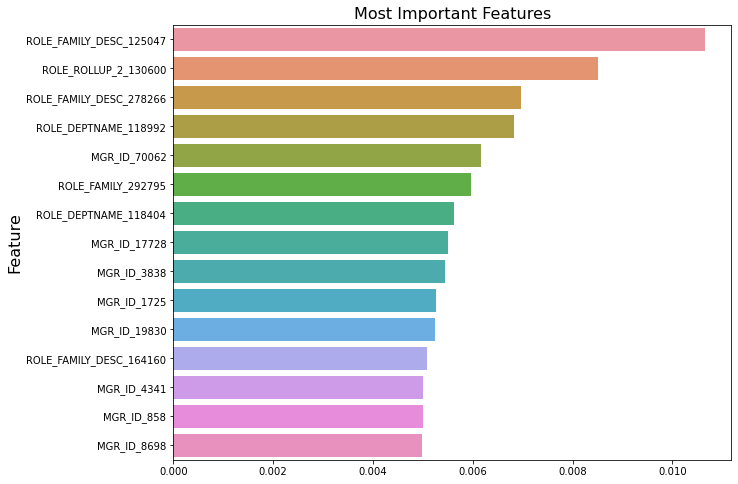

In [24]:
plot_feature_importance(feature_columns, xgb_clf.feature_importances_, top_n_features=15)

In [25]:
performance_measures(xgb_clf)

Mean Train MCC: 0.39076287637260154
Mean Test MCC: 0.22660323395234597
Mean Train ROC AUC Score: 0.8358825281806868
Mean Test ROC AUC Score: 0.7254743012261117


CatBoost

In [24]:
from catboost import CatBoostClassifier

catboost_clf = CatBoostClassifier(loss_function='Logloss', iterations=500, depth=6, l2_leaf_reg=1, 
                                  cat_features=list(range(X_cb_train_transformed.shape[1])), 
                                  eval_metric='AUC', random_state=42, verbose=0)
catboost_clf.fit(X_cb_train_transformed, y_train)

In [25]:
performance_measures(catboost_clf, X_tr=X_cb_train_transformed, X_ts=X_cb_test_transformed)

Mean Train MCC: 0.4899935020477274
Mean Test MCC: 0.25841488658401285
Mean Train ROC AUC Score: 0.8812279401777584
Mean Test ROC AUC Score: 0.7782526101252574


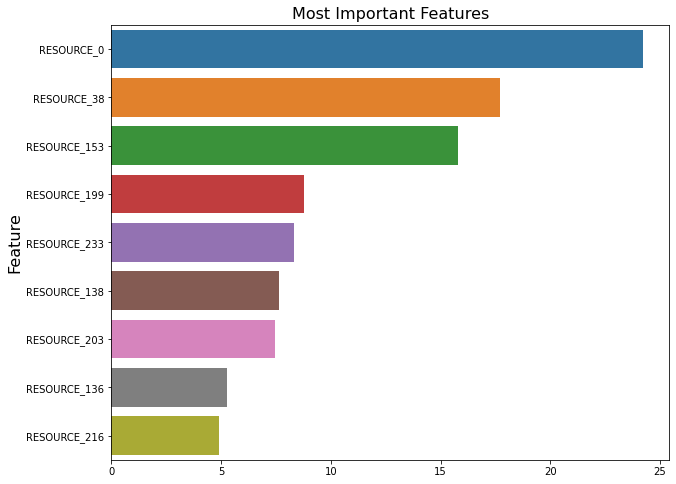

In [26]:
plot_feature_importance(feature_columns, catboost_clf.feature_importances_, top_n_features=15)

LightGBM

In [29]:
from lightgbm import LGBMClassifier
model = LGBMClassifier()
model.fit(X_train_transformed, y_train)

LGBMClassifier()

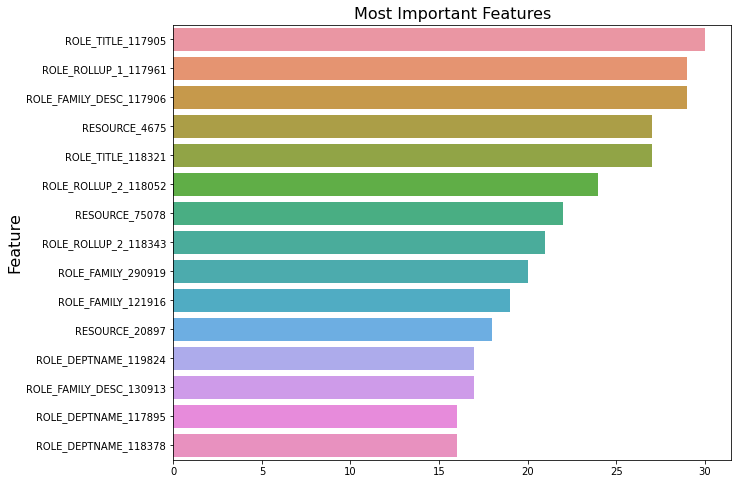

In [30]:
plot_feature_importance(feature_columns, model.feature_importances_, top_n_features=15)

In [31]:
performance_measures(model)

Mean Train MCC: 0.22872969209445185
Mean Test MCC: 0.1584894411305095
Mean Train ROC AUC Score: 0.8177179830855893
Mean Test ROC AUC Score: 0.7109834573207993


In [32]:
xgb_clf_pipeline = Pipeline([('pre_process', pre_process), ('xgb_clf', xgb_clf)])
catboost_clf_pipeline = Pipeline([('pre_process', cat_boost_pre_process), ('catboost_clf', catboost_clf)])
model_pipeline = Pipeline([('pre_process', pre_process), ('model', model)])

named_estimators = [('xgb_clf', xgb_clf_pipeline), ('catboost_clf', catboost_clf_pipeline), ('model', model_pipeline)]

## Model Evaluation

In [33]:
result_df = pd.DataFrame(results, columns=['Model', 'CV Train AUC Score', 'CV Test AUC Score', 'CV Train MCC', 'CV Test MCC'])
result_df

,Model,CV Train AUC Score,CV Test AUC Score,CV Train MCC,CV Test MCC
0,XGBClassifier,0.836,0.725,0.391,0.227
1,CatBoostClassifier,0.882,0.778,0.490,0.258
2,LGBMClassifier,0.818,0.711,0.229,0.158


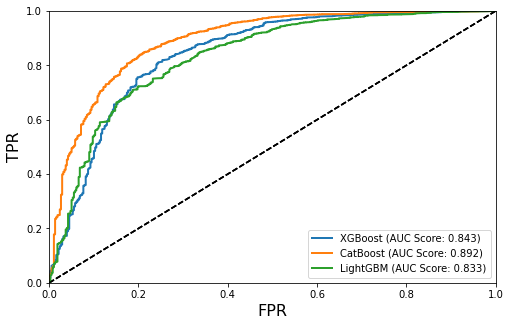

In [34]:
plt.figure(figsize=(8, 5))
plot_custom_roc_curve('XGBoost', y_test, xgb_clf.predict_proba(X_test_transformed)[:,1])
plot_custom_roc_curve('CatBoost', y_test, catboost_clf.predict_proba(X_cb_test_transformed)[:,1])
plot_custom_roc_curve('LightGBM', y_test, model.predict_proba(X_test_transformed)[:,1])
plt.show()